## Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [1]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the HSC-SSP AGN table

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [2]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
# data_agn

1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

Source profile

In [3]:
source_profile = '''
r_z  bibcode             description        comment
---- ------------------- ------------------ ----------------------
0    see-below           SIMBAD             -
1    see-below           HSC-DR3            -
2    2018ApJ...858...77H DEIMOS             -
3    2016ApJ...819...62C COSMOS2020         -
4    see-below           Kiruma20           -
z0_1 2009ApJ...696.1195T Magellean          -
z0_2 2015ApJS..220...12S -                  -
z0_3 2018ApJ...858...77H DEIMOS             -
z0_4 2018ApJ...869...20B -                  -
z0_5 2018ApJS..234...21D -                  -
z0_6 2018ApJS..239...27S -                  -
z0_7 2018PASJ...70S..10O -                  -
z0_8 2019ApJ...877...81M -                  -
z0_9 2020AJ....160...37M -                  -
z1_1 2009ApJS..184..218L zCOSMOS DR3        may overestimate z
z1_2 2016ApJS..225...27M 3D-HST v4.1.5      -
z1_3 2020ApJS..249....3A SDSS DR15          -
z1_4 2017ApJ...841..111M C3R2 DR2           -
z1_5 2013A&A...559A..14L VVDS DRFinal       -
z1_6 2018ApJ...858...77H DEIMOS             -
z1_7 2015ApJS..220...12S FMOS COSMOS DR2    -
z1_8 2018ApJS..239...27S LEGA-C DR2         -
z1_9 2013ApJ...767..118C PRIMUS             prism, underestimate z
z4_1 2020ApJ...894...24K HSC DR2            -
z4_2 2018ApJ...858...77H DEIMOS             -
z4_3 2016ApJ...817...34M Chandra photz      -
z4_4 2016ApJS..224...24L COSMOS2015 photz   -
'''

with open('source_profile.txt', 'w') as f: 
    f.write(source_profile[1:])

# ascii.read('source_profile.txt')

Prepare the updated table by copying and adding extra columns 
Only keep DRIMOS (r_z=2) since r_z=1 is DR2 and r_z=3&1 is phot-z

In [4]:
data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['z4'] = data_agn['z']
data_agn_updated['r_z4'] = data_agn['r_z']
data_agn_updated['z'] = -1.
data_agn_updated['r_z'] = -1

data_agn_updated['z2'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==2: 
        data_agn_updated['z2'][i] = data_agn['z'][i]

data_agn_updated.meta['comments'] = source_profile.split('\n')

data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,z4,r_z4,z2
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,float64,int64,float64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,-1.0,-1,594392,1.561,3,-1.0
2,150.73557,2.19957,20.36,1,1,1,1,1,6,-1.0,-1,592797,3.499,1,-1.0
3,150.73353,2.15646,20.88,1,1,1,1,1,6,-1.0,-1,565402,0.977,1,-1.0
4,150.79702,2.13888,21.01,1,1,1,1,1,6,-1.0,-1,552225,0.573,1,-1.0
5,150.78259,2.19306,20.63,1,1,1,1,1,6,-1.0,-1,589540,0.585,1,-1.0
6,150.72019,2.24803,21.13,1,1,1,1,1,6,-1.0,-1,625595,0.664,1,-1.0
7,150.78838,2.34399,19.82,1,1,1,1,1,6,-1.0,-1,689768,1.964,1,-1.0
8,150.71511,2.48483,19.2,1,1,1,1,1,6,-1.0,-1,782508,1.999,1,-1.0


### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [5]:
from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

313


/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


add result into updated table (bibcode incomplete)

In [6]:
np.unique(result_table[mask_spec_simbad]['RVZ_BIBCODE'], return_counts=True)

(<MaskedColumn name='RVZ_BIBCODE' dtype='object' length=27>
 2007ApJS..172...70L
 2009ApJ...693....8B
 2009ApJ...696.1195T
 2012ApJ...753..121K
 2012ApJ...758...47A
 2012ApJS..203...21A
 2014A&A...563A..54P
 2014MNRAS.443.2679B
 2015ApJS..219...12A
 2015ApJS..220...12S
 2016MNRAS.456.1195H
 2016MNRAS.458.4321K
                 ...
 2018ApJ...858...77H
 2018ApJ...869...20B
 2018ApJS..234...21D
 2018ApJS..239...27S
 2018PASJ...70S..10O
 2019ApJ...877...81M
 2020A&A...633A.159R
 2020AJ....160...37M
 2020ApJ...903...24M
 2020ApJS..250....8L
 2021ApJS..256....9S
 2021ApJS..256...44V,
 array([ 32,   1, 178,   1,   2,   1,   4,   3,   4,   4,   1,   1,   1,
          1,   2,  45,   2,   4,   1,   1,   1,   1,   4,   1,   1,   1,
         11]))

In [7]:
data_agn_updated['z0'] = -1.
data_agn_updated['r_z0'] = None

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

source_codes = {
    '2009ApJ...696.1195T': 1,
    '2015ApJS..220...12S': 2,
    '2018ApJ...858...77H': 3,
    '2018ApJ...869...20B': 4,
    '2018ApJS..234...21D': 5,
    '2018ApJS..239...27S': 6,
    '2018PASJ...70S..10O': 7,
    '2019ApJ...877...81M': 8,
    '2020AJ....160...37M': 9
}

for j,i in enumerate(idx_simbad_specz):
    data_agn_updated['z0'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated['r_z0'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]

### Match to HSC PDR3 

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

#### Obtain the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the spec-z in COSMOS field. I have renamed it to `hsc-spec-cosmos.txt`

In [8]:
data_coords = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit=u.deg)
print(len(data_coords))

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('hsc-spec-cosmos.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, d3d = data_coords.search_around_sky(hsc_coords, 0.5*u.arcsec)
# Index to mask


print(len(hsc_targets[idx_hsc_pdr3]))
# plt.hist(d2d.to(u.arcsec).value, bins=100);

491
379


Fill in the updated table

In [9]:
data_agn_updated['z1'] = -1.
data_agn_updated['r_z1'] = -1

ref_codes = {
    'specz_flag_zcosmos_bright_dr3': 1,
    'specz_flag_3dhst_v4_1_5':       2,
    'specz_flag_sdss_dr15':          3,
    'specz_flag_c3r2_dr2':           4,
    'specz_flag_vvds_drfinal':       5,
    'specz_flag_deimos_2018':        6,
    'specz_flag_fmos_dr2':           7,
    'specz_flag_lega_c_dr2':         8,
    'specz_flag_primus_dr1':         9,
}

for j,i in enumerate(idx_hsc_specz):
    data_agn_updated['z1'][i] = hsc_targets['specz_redshift'][idx_hsc_pdr3[j]]
    source_key = [key for key in source_keys if hsc_targets[i][key]==True][0]
    data_agn_updated['r_z1'][i] = ref_codes[source_key]

### Match to COSMOS2020 and Chandra COSMOS Legacy to get photometry and photo-z

#### COSMOS2020

https://cosmos2020.calet.org/catalogues/

Format : https://cosmos2020.calet.org/catalogues/COSMOS2020_DR4_1_1.pdf

In [10]:
# Read
dir_in = './'  
catversion = 'Farmer' 
data_cosmos2020 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

# Create a mask to restrict the analysis to a subset of filters (optional)
# 'CHANDRA'
filt_use = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_mask = [i in filt_use for i in filt_name]

whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(data_cosmos2020)))
#data_cosmos2020 = data_cosmos2020[data_cosmos2020['FLAG_{}'.format(whichflag)]==0]
#print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(data_cosmos2020)))

The parent sample includes 964506 sources


Actually do the matching to COSMOS2020

In [11]:
cat_COSMOS2020 = SkyCoord(data_cosmos2020['ALPHA_J2000'], data_cosmos2020['DELTA_J2000'], unit='deg')

idx_agn2COSMOS20, idx_COSMOS20, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.6*u.arcsec)
# MISSING A FEW SOURCES COSMOS2015->COSMOS2020
print(len(idx_COSMOS20), print(len(cat_agn)))

491
455 None


fill in the table

In [12]:
data_agn_updated['z3'] = -1. 

data_agn_updated['z3'][idx_agn2COSMOS20] = data_cosmos2020['lp_zq'][idx_COSMOS20]
data_agn_updated['z3'][~np.isfinite(data_agn_updated['z3'])] = -1.

### Photo-z comparison

Lephare includes AGN component. Even then, the photo-z's are rough

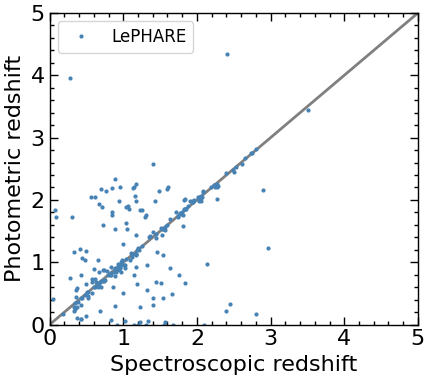

In [13]:
z_hsc = data_agn['z'][idx_agn2COSMOS20]

z_agn = data_cosmos2020['lp_zq'][idx_COSMOS20]

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 2

fig, ax = plt.subplots(1,1, figsize=(4.5, 4))

ax.errorbar(z_hsc[mask_spec], z_agn[mask_spec], color='steelblue',
            marker='.', ms=4, linestyle='none', label='LePHARE')

ax.set_xlabel('Spectroscopic redshift')
ax.set_ylabel('Photometric redshift')


ax.legend(frameon=True, fontsize=12)
ax.plot([-1, 5], [-1, 5], color='gray', zorder=-1)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

fig.tight_layout()
fig.savefig('photoz.pdf', dpi=300)

Some of these spec-z's are wrong so careful there

### Compile the above data

fill out the best z column by overwriting with 

SIMBAD > HSC > DEIMOS > COSMOS2020 > original

z0 > z1 > z2 > z3 > z4

In [14]:
for i in [4, 3, 2, 1, 0]: 
    mask_z = data_agn_updated['z%d'%i]!=-1
    data_agn_updated['z'][mask_z] = data_agn_updated['z%d'%i][mask_z]
    data_agn_updated['r_z'][mask_z] = i

data_agn_updated = data_agn_updated['ID', 'RAdeg', 'DEdeg', 'i-mag', 'X-flag', 'g-flag', 'r-flag', 'i-flag', 'z-flag', 'n-corr', 'ID-COSMOS2015', 'z', 'z0', 'z1', 'z2', 'z3', 'z4', 'r_z', 'r_z0', 'r_z1', 'r_z4']

data_agn_updated.write('hsc_agn_updated.txt', format='ascii', overwrite=True)
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z0,z1,z2,z3,z4,r_z,r_z0,r_z1,r_z4
--,deg,deg,mag,--,--,--,--,--,--,--,--,,,,,--,--,,,--
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,object,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,594392,1.58,-1.0,-1.0,-1.0,1.58,1.561,3,None,-1,3
2,150.73557,2.19957,20.36,1,1,1,1,1,6,592797,3.5026,3.5026,3.503096,-1.0,-1.0,3.499,0,2014A&A...563A..54P,2,1
3,150.73353,2.15646,20.88,1,1,1,1,1,6,565402,0.979,0.979,0.9769,-1.0,1.03,0.977,0,2009ApJ...696.1195T,2,1
4,150.79702,2.13888,21.01,1,1,1,1,1,6,552225,0.5727,0.5727,0.5727,-1.0,0.51,0.573,0,2018A&A...611A..53J,2,1
5,150.78259,2.19306,20.63,1,1,1,1,1,6,589540,0.5824,0.5824,0.5847,-1.0,-1.0,0.585,0,2009ApJ...696.1195T,2,1
6,150.72019,2.24803,21.13,1,1,1,1,1,6,625595,0.6652,0.6652,0.6633,-1.0,0.62,0.664,0,2009ApJ...696.1195T,2,1
7,150.78838,2.34399,19.82,1,1,1,1,1,6,689768,1.9555,1.9555,1.964449,-1.0,2.0,1.964,0,2009ApJ...696.1195T,2,1
8,150.71511,2.48483,19.2,1,1,1,1,1,6,782508,2.0051,2.0051,1.995,-1.0,-1.0,1.999,0,2009ApJ...696.1195T,2,1


#### Visually check our data completeness

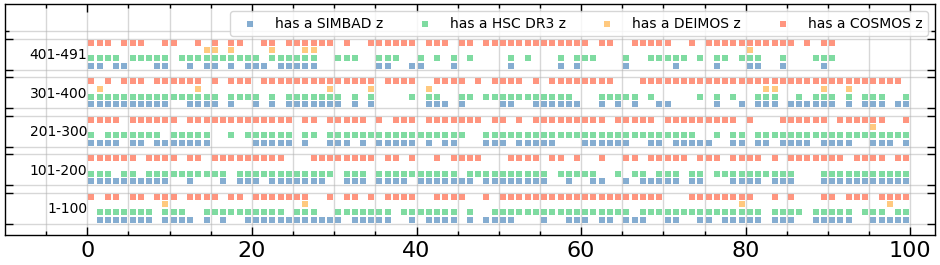

In [15]:
plt.figure(figsize=[12, 3])

ID = data_agn_updated['ID']
mask_simbad = data_agn_updated['z0']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_simbad], ((ID-1)//100+0.1)[mask_simbad], linewidths=0, alpha=0.5, s=20, marker='s', label='has a SIMBAD z')
mask_hsc = data_agn_updated['z1']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_hsc], ((ID-1)//100+0.1+0.2)[mask_hsc], linewidths=0, alpha=0.5, s=20, marker='s', label='has a HSC DR3 z')
mask_deimos = data_agn_updated['z2']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_deimos], ((ID-1)//100+0.1+0.4)[mask_deimos], linewidths=0, alpha=0.5, s=20, marker='s', label='has a DEIMOS z')
mask_cosmos = data_agn_updated['z3']!=-1.
plt.scatter(((ID-1)%100+0.5)[mask_cosmos], ((ID-1)//100+0.1+0.6)[mask_cosmos], linewidths=0, alpha=0.5, s=20, marker='s', label='has a COSMOS z')

plt.legend(frameon=True, ncol=4, fontsize=10)
plt.text(-0, 0.4, '1-100', size=10, ha='right', va='center')
plt.text(-0, 1.4, '101-200', size=10, ha='right', va='center')
plt.text(-0, 2.4, '201-300', size=10, ha='right', va='center')
plt.text(-0, 3.4, '301-400', size=10, ha='right', va='center')
plt.text(-0, 4.4, '401-491', size=10, ha='right', va='center')
plt.xlim(-10, 103)
plt.ylim(-0.3, 5.7)

plt.yticks([0, 0.8, 1, 1.8, 2, 2.8, 3, 3.8, 4, 4.8], '')
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.5)

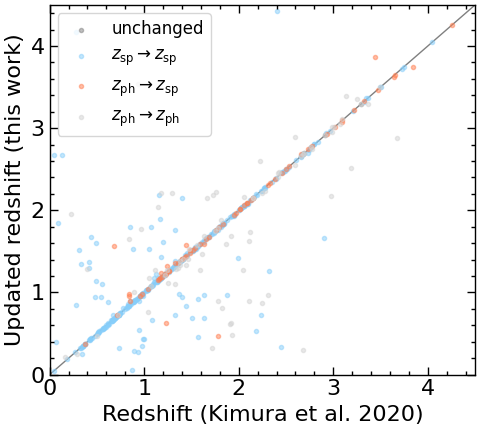

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_unchanged = (data_agn_updated['r_z']==4)
ax.scatter(data_agn_updated['z4'][mask_unchanged], data_agn_updated['z'][mask_unchanged], 
           marker='.', color='gray', label=r'unchanged', alpha=0.5)

mask_sp2sp = (data_agn_updated['r_z4']<=2) & (data_agn_updated['r_z']<=2)
ax.scatter(data_agn_updated['z4'][mask_sp2sp], data_agn_updated['z'][mask_sp2sp], 
           marker='.', color='lightskyblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2sp = (data_agn_updated['r_z4']>=3) & (data_agn_updated['r_z']<=2)
ax.scatter(data_agn_updated['z4'][mask_ph2sp], data_agn_updated['z'][mask_ph2sp], 
           marker='.', color='coral', label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$', alpha=0.5)

mask_ph2ph = (data_agn_updated['r_z4']>=3) & (data_agn_updated['r_z']>=3)
ax.scatter(data_agn_updated['z4'][mask_ph2ph], data_agn_updated['z'][mask_ph2ph], 
           marker='.', color='lightgray', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', alpha=0.5)

# mask_sp2ph = (data_agn_updated['r_z4']<=2) & (data_agn_updated['r_z']>=3)
# ax.scatter(data_agn_updated['z4'][mask_sp2ph], data_agn_updated['z'][mask_sp2ph], 
#            marker='.', color='r', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$')


ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')

ax.set_xlabel('Redshift (Kimura et al. 2020)')
ax.set_ylabel('Updated redshift (this work)')
ax.legend(frameon=True, loc=2, fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

manually check inconsistent zs

In [17]:
z_list = ['z0', 'z1', 'z2']
inconsistent_z = table.Table(names=(['ID']+z_list), dtype=([np.int64]+[np.float64]*len(z_list)))
for i in range(len(data_agn_updated)): 
    z = data_agn_updated[i][z_list]
    z_filtered = [j for j in z if j!=-1.]
    if z_filtered!=[]: 
        if np.max(z_filtered)-np.min(z_filtered)>0.1: 
            inconsistent_z.add_row(data_agn_updated[i][['ID'] + z_list])
            # print(data_agn_download[ID][['ID'] + z_list])
inconsistent_z.pprint_all()

 ID    z0        z1       z2 
--- ------- ----------- -----
 11   0.925      1.5652  -1.0
 17  1.2651      2.3219  -1.0
 27  0.9736       1.634 1.634
 40  1.1433      0.4924  -1.0
 76  0.8913   1.5563668  -1.0
 90  1.2995  0.42066365  -1.0
103   1.606   0.4906261  -1.0
127   1.797   1.0733103  -1.0
137  2.1458     1.40008  -1.0
139  1.5145      1.9289  -1.0
145  0.9793      1.7592  -1.0
153   0.695    1.001973  -1.0
193   2.673 0.045087364  -1.0
197    0.34      1.9582  -1.0
201  1.8456 0.090319805  -1.0
206  0.4967      0.6911  -1.0
221  0.3236      0.7344  -1.0
223 0.74829      0.5773  -1.0
227  0.4586      1.5659  -1.0
237  2.6681  0.13425398  -1.0
256  1.4797   0.3996155  -1.0
257  0.4319   1.0107826  -1.0
270  1.7977   0.8445786  -1.0
273  0.4311       1.596  -1.0
292  0.5368   0.9435049  -1.0
300    4.17   0.2762015  -1.0
331  0.7284      2.2335  -1.0
367  0.7252      1.3247  -1.0
384  0.9388      1.3955 1.395
400   0.942   1.0770499  -1.0
416   0.277       0.933 0.933
420   0.88

below are incomplete parts

Create a bar chart of where our data comes from 

In [18]:
# HSC (matched in HSC catalog)
hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])
hsc_sources_filtered = {key:value for key, value in zip(hsc_sources.keys(), hsc_sources.values()) if value!=0}

# simbad (others than above)
using_simbad_mask = [i not in idx_hsc_specz for i in data_agn_updated['ID']-1]
bibcodes, _ = np.unique(data_agn_updated['bibcode'][using_simbad_mask], return_counts=True)
simbad_sources = {}
for key in bibcodes: 
    simbad_sources[key] = np.count_nonzero(data_agn_updated['bibcode'][using_simbad_mask]==key)

joint_source = {}
joint_source.update(hsc_sources_filtered)
joint_source.update(simbad_sources)
convert_bibcodes = { 
    'specz_flag_zcosmos_bright_dr3':['zCOSMOS DR3 (in HSC)',    'Y', '2009ApJS..184..218L', 'overestimate z'], 
    'specz_flag_3dhst_v4_1_5':      ['3D-HST v4.1.5 (in HSC)',  '?', '2016ApJS..225...27M', ''], 
    'specz_flag_sdss_dr15':         ['SDSS-DR15 (in HSC)',      'Y', '2020ApJS..249....3A', ''], 
    'specz_flag_c3r2_dr2':          ['C3R2 DR2 (in HSC)',       '?', '2017ApJ...841..111M', ''], 
    'specz_flag_vvds_drfinal':      ['VVDS DRFinal (in HSC)',   '?', '2013A&A...559A..14L', ''], 
    'specz_flag_deimos_2018':       ['DEIMOS (in HSC)',         'N', '2018ApJ...858...77H', 'no website'], 
    'specz_flag_fmos_dr2':          ['FMOS-COSMOS DR2 (in HSC)','?', '2015ApJS..220...12S', ''], 
    'specz_flag_lega_c_dr2':        ['LEGA-C DR2 (in HSC)',     '?', '2018ApJS..239...27S', ''], 
    'specz_flag_primus_dr1':        ['PRIMUS (in HSC)',         'N', '2013ApJ...767..118C', 'prism, underestimate z'], 
    '-------------------':          ['not specified',           '?', '-------------------', ''], 
    '2009ApJ...696.1195T':          ['Magellean/zCOSMOS',       'Y', '2009ApJ...696.1195T', ''], 
    '2015ApJS..220...12S':          ['2015ApJS..220...12S',     '?', '2015ApJS..220...12S', ''], 
    '2018ApJ...858...77H':          ['DEIMOS',                  'N', '2018ApJ...858...77H', 'spectra not available'], 
    '2018ApJ...869...20B':          ['2018ApJ...869...20B',     '?', '2018ApJ...869...20B', ''], 
    '2018ApJS..234...21D':          ['2018ApJS..234...21D',     '?', '2018ApJS..234...21D', ''], 
    '2018ApJS..239...27S':          ['2018ApJS..239...27S',     '?', '2018ApJS..239...27S', ''], 
    '2018PASJ...70S..10O':          ['2018PASJ...70S..10O',     '?', '2018PASJ...70S..10O', ''], 
    '2019ApJ...877...81M':          ['2019ApJ...877...81M',     '?', '2019ApJ...877...81M', ''], 
    '2020AJ....160...37M':          ['2020AJ....160...37M',     '?', '2020AJ....160...37M', ''], 
    '2020ApJ...894...24K':          ['Yuki K. (2020)',          'N', '2020ApJ...894...24K', 'HSC QSO catalog we used'], 
    '2021ApJS..256....9S':          ['2021ApJS..256....9S',     '?', '2021ApJS..256....9S', ''], 
    '2016ApJ...817...34M':          ['Chandra (may phot-z)',    '?', '2016ApJ...817...34M', ''], 
    '2016ApJS..224...24L':          ['COSMOS2015 (may phot-z)', '?', '2016ApJS..224...24L', '']}

# make a table
source_table = table.Table([[convert_bibcodes[key][0] for key in joint_source.keys()], 
                            list(joint_source.values()), 
                            [convert_bibcodes[key][1] for key in joint_source.keys()], 
                            [convert_bibcodes[key][2] for key in joint_source.keys()],
                            [convert_bibcodes[key][3] for key in joint_source.keys()], ], 
                           names=('source', 'count', 'availability', 'bibcode', 'comment'))
# TODO: complete this table
source_table

# # make a figure
# fig, ax = plt.subplots(1,1, figsize=(7, 6))
# ax.bar([key for key in joint_source.keys()], joint_source.values())
# for c in ax.containers:
#     ax.bar_label(c)
# plt.xticks(rotation=60, ha='right', rotation_mode='anchor');
# ax.set_ylabel('Number')
# fig.tight_layout()
# fig.savefig('specz_source.pdf', dpi=300); [convert_bibcodes[key] for key in joint_source.keys()]

KeyError: 'bibcode'

Check if SIMBAD spec-z and paper spec-z are consistent

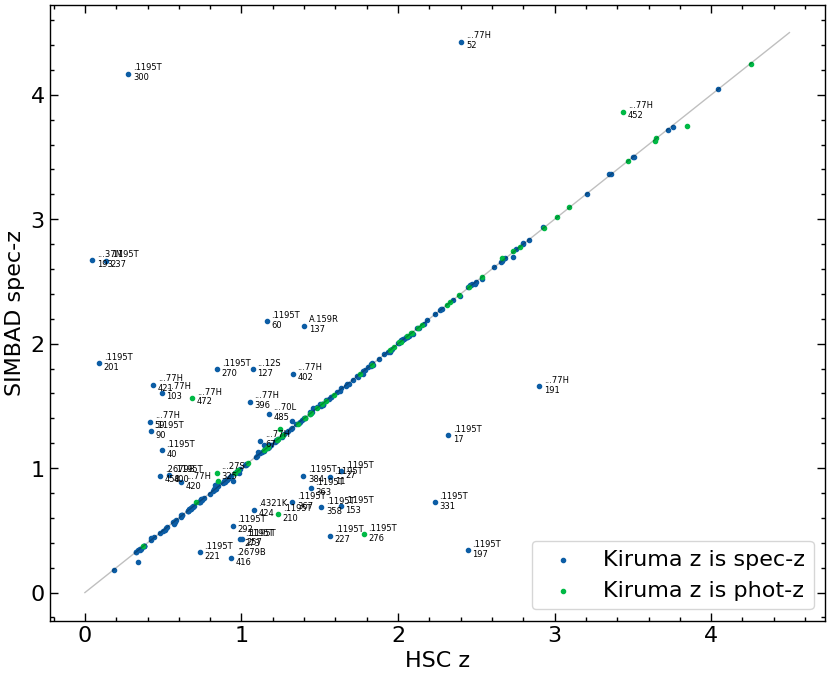

In [ ]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]

plt.figure(figsize=[10, 8])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='Kiruma z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='Kiruma z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()


### Add photometry to updated file

In [ ]:
data_agn_updated

In [ ]:
data_agn_updated['ez_z_phot'] = data_cosmos2020j['ez_z_phot'][idx_COSMOS20].data.data



array([11.867114  ,  0.13636474,  1.7944578 ,  0.6991306 ,         nan,
        1.7872384 , 11.935175  ,  1.8436909 ,  0.76585656,  0.05651569,
        0.21207878,  3.0050943 ,  1.7360985 ,  0.2088695 , 11.935175  ,
       11.935175  ,  2.7708206 ,  3.21618   ,         nan,  0.61776966,
       11.935175  ,  1.7932739 ,  0.64357924,  3.6862168 ,  0.8417419 ,
        1.6844636 ,  2.7572834 ,  2.6353614 , 11.935175  ,  0.39303407,
               nan,  2.269821  ,  1.8551476 ,  0.31647202,  0.6411418 ,
        0.5088285 ,  1.4864419 ,  2.9942727 ,  0.05294272,  0.74966055,
        1.5039822 ,  2.8294468 ,         nan,         nan,  0.8574199 ,
               nan,         nan,  0.7647905 ,  0.7049937 ,  4.4960165 ,
        0.28442654,  2.7954786 ,  1.7770007 ,  1.2731855 , 11.935175  ,
        3.0406983 , 11.935175  , 11.935175  ,  0.29259223,  0.0922895 ,
        2.8010075 ,  1.941736  ,  0.42288867,  1.2557203 , 11.935175  ,
        0.73963463,  1.0374533 , 11.898824  , 11.7204685 ,      